# 0.0

Descrição do problema de negócio

A InStyle é uma das maiores lojas de roupas dos Estados Unidos que passa por problemas de customer experience ou experiência do cliente.

O grande desafio de escalar o faturamento de uma loja é manter a qualidade do produto e a taxa de satisfação do cliente em alta.

À medida que a empresa alcance mais clientes, os processos internos de vendas que começa com a concepção do produto, passam pela divulgação do marketing e chegam até os sistemas de pagamento do financeiro começam a apresentar problemas.

O time de produtos tem dificuldade em determinar a necessidade da maioria dos clientes. O time de marketing enfrente desafios para determinar o cliente ideal e o time de desenvolvimento sofre com os grandes volumes de acessos no site e em seu aplicativo, causando quedas de sistema e tornando o site inoperante por algumas horas, impedindo as pessoas de comprar e assim, gerando muitas reclamações no atendimento, liderado pelo time de customer experience.

Portanto, a medição da satisfação dos clientes é extremamente importante para a empresa manter a boa reputação no mercado.

Um time interdisciplinar chamado de “War Room”, formado por profissionais de Produto, Marketing, Design, Dados e Desenvolvimento foi montado para garantir uma ótima experiência de compra ao cliente e uma alta taxa de satisfação, mesmo com o crescimento rápido do volume de vendas.

Uma das primeiras ações emergenciais do War Room foi fazer um atendimento pessoal aos clientes. Porém, a dificuldade inicial era identificar quais clientes teriam um nível de satisfação “Satisfeito” ou “Neutro/Insatisfeito”, para que o time conseguisse entrar em contato somente com os clientes “Neutro/Insatisfeito”.

Os Cientistas de Dados do War Room ficaram com a tarefa de treinar um algoritmo para classificar os clientes de uma planilha em “Satisfeito” ou “Neutro/Insatisfeito”, prevendo quais clientes ficarão Insatisfeitos e portanto agindo rápido para entender o motivo da insatisfação e reverter o cenário do cliente.

In [75]:
import os
import numpy                as np
import pandas               as pd
import pickle
import seaborn              as sns
import inflection
import matplotlib.pyplot    as plt 
import plotly.graph_objects as go

from sklearn                    import preprocessing as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix
from  xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
def desc_num(num_attributes):
    #Medidas de tendencia central - mmedia e mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #Medidas de dispersão - desvio padrão, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

    display(m)

In [77]:
BASE_DIR = os.path.abspath('')
DATA_DIR = os.path.join(BASE_DIR,'data')
#IMAG_DIR = os.path.join(BASE_DIR,'images')
MODE_DIR = os.path.join(BASE_DIR,'models')

df_raw = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))

# 1.0 Descrição dos dados

## 1.1 Renomeando Colunas

In [78]:
df1 = df_raw.copy()
#0 Neutro
#1 satisfeito

In [79]:
df1.columns = ['id','gender','customer_type','age','type_of_purchase','store_size','store_distance','in_store_wifi',
               'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning','dressing_room','waiting_room',
               'kids_entertainment','seller_service','showroom','self_store','purchase_service','store_service','cleanliness','carrier_delay_in_minutes',
               'delivery_delay_in_minutes','satisfaction']

## 1.2 Descrição de features

In [80]:
num_attributes = df1.drop(['id'],axis=1).select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


display(num_attributes.apply(lambda x: x.unique().shape[0]))
display(cat_attributes.apply(lambda x: x.unique()))

age                             75
store_distance                3802
in_store_wifi                    6
open_close_time_convenient       6
easy_of_online_shopping          6
store_location                   6
toilet_cleaning                  6
dressing_room                    6
waiting_room                     6
kids_entertainment               6
seller_service                   6
showroom                         6
self_store                       5
purchase_service                 6
store_service                    6
cleanliness                      6
carrier_delay_in_minutes       446
delivery_delay_in_minutes      456
dtype: int64

gender                                       [Male, Female]
customer_type           [Loyal Customer, disloyal Customer]
type_of_purchase                           [Personal, Gift]
store_size                           [Small, Large, Medium]
satisfaction        [Neutral or Dissatisfaction, Satisfied]
dtype: object

In [81]:
desc_num(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,7.0,85.0,78.0,39.379706,40.0,15.114891,-0.004516,-0.719568
1,store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.142482,1.109466,0.268535
2,in_store_wifi,0.0,5.0,5.0,2.729683,3.0,1.327823,0.040408,-0.846170
3,open_close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525068,-0.334399,-1.037767
4,easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398923,-0.018294,-0.910346
5,store_location,0.0,5.0,5.0,2.976883,3.0,1.277615,-0.058889,-1.030283
6,toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329526,-0.151279,-1.145453
7,dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349502,-0.453852,-0.702006
8,waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319081,-0.482775,-0.925702
9,kids_entertainment,0.0,5.0,5.0,3.358158,4.0,1.332984,-0.365131,-1.060696


## 1.3 Tipos e dimensões dos dados

In [82]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))
display(df1.dtypes)
display(df1.describe())

Number of Rows: 103904
Number of Columns: 24


id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
in_store_wifi                   int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

,id,age,store_distance,in_store_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## 1.4 Valores Nulos

In [83]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
in_store_wifi                   0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self_store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     310
satisfaction                    0
dtype: int64

## 1.5 Preenchimento/Alteração dos valores

In [84]:
#age                             75
#store_distance                3802
#in_store_wifi                    6
#open_close_time_convenient       6
#easy_of_online_shopping          6
#store_location                   6
#toilet_cleaning                  6
#dressing_room                    6
#waiting_room                     6
#kids_entertainment               6
#seller_service                   6
#showroom                         6
#self_store                       5
#purchase_service                 6
#store_service                    6
#cleanliness                      6
#carrier_delay_in_minutes       446
#delivery_delay_in_minutes      456

#gender                                       [Male, Female] (0 = Male, 1 = Female)
#customer_type           [Loyal Customer, disloyal Customer] (0 = Leal, 1 = "desleal")
#type_of_purchase                           [Personal, Gift] (0 = pessoal, 1 = presente)
#store_size                           [Small, Large, Medium] (1 = pequeno, 2=médio, 3=grande)
#satisfaction        [Neutral or Dissatisfaction, Satisfied] (0 = não satisfeito, 1 = satisfeito)

In [85]:
df1['gender'] =             [0 if x == 'Male'                       else 1 for x in df1['gender']]
df1['customer_type'] =      [0 if x == 'Loyal Customer'             else 1 for x in df1['customer_type']]
df1['type_of_purchase'] =   [0 if x == 'Personal'                   else 1 for x in df1['type_of_purchase']]
df1['satisfaction'] =       [0 if x == 'Neutral or Dissatisfaction' else 1 for x in df1['satisfaction']]
df1['store_size'] =         [1 if x == 'Small'                      else 2 if x=='Medium' else 3 for x in df1['store_size']]

In [86]:
df2 = df1.copy()

df2 = df1[df1['delivery_delay_in_minutes']<600]
df2 = df2[df2['carrier_delay_in_minutes']<600]
df2 = df2[df2['delivery_delay_in_minutes'].notnull()]


# 2.0 Feature Engineering

In [87]:
df3 = df2.copy()

## 2.1 Mapa Mental

In [88]:
#<img src='images/Satisfao_do_Cliente.png' width='900'>

## 2.2 Criação de Hipóteses

### 2.2.1 Hipótese de Lojas

 - 1. Lojas mais próximas de centro deveriam satisfazer mais o cliente.

 - 2. Lojas pequenas tem maior numero de clientes insatisfeitos

### 2.2.2 Hipótese sobre os Clientes

- 1. Pessoas com mais que 45 anos tendem a  ficar insatisfeitas com a loja. (Lembrar de excluir a faixa etaria infantil)

- 2. Mulheres tendem a ficar mais insatisfeitas com a loja

- 3. Clientes fieis tendem a serem mais satisfeitos com a loja

- 4. 

### 2.2.3 Hipóteses Produto

- 1. Clientes satisfeitos tendem a comprar para presentes


### 2.2.4 Hipótese experiência do cliente

- 1. Tempo de entrega menor deveriam deixar o cliente mais satisfeitos

- 2. Os sites mais intuitivos deveriam deixar o cliente mais satisfeito

In [89]:
#age                             75
#store_distance                3802
#in_store_wifi                    6
#open_close_time_convenient       6
#easy_of_online_shopping          6
#store_location                   6
#toilet_cleaning                  6
#dressing_room                    6
#waiting_room                     6
#kids_entertainment               6
#seller_service                   6
#showroom                         6
#self_store                       5
#purchase_service                 6
#store_service                    6
#cleanliness                      6
#carrier_delay_in_minutes       446
#delivery_delay_in_minutes      456


#gender                                       [Male, Female] (0 = Male, 1 = Female)
#customer_type           [Loyal Customer, disloyal Customer] (0 = Leal, 1 = "desleal")
#type_of_purchase                           [Personal, Gift] (0 = pessoal, 1 = presente)
#store_size                           [Small, Large, Medium] (1 = pequeno, 2=médio, 3=grande)
#satisfaction        [Neutral or Dissatisfaction, Satisfied] (0 = não satisfeito, 1 = satisfeito)

### 2.3 Feature Engineering

#### 2.3.1 Criação de feature média das notas

In [90]:
score_features = ['in_store_wifi',
'open_close_time_convenient',
'easy_of_online_shopping',
'store_location',
'toilet_cleaning',
'dressing_room',
'waiting_room',
'kids_entertainment',
'seller_service',
'showroom',
'self_store',
'purchase_service',
'store_service',
'cleanliness']

aux = df3[score_features]
df3['media_score'] = np.mean(aux, axis=1)


bins = [0, 18, 45, float('inf')]
labels = ['0-18', '19-45', '45+']

aux=df3.copy()
aux['age_group'] = pd.cut(aux['age'], bins=bins, labels=labels, right=False)

# 3.0 Filtragem de variaveis

# 4.0 EDA

In [91]:
df4 = df3.copy()

## 4.1 Balanço dos dados

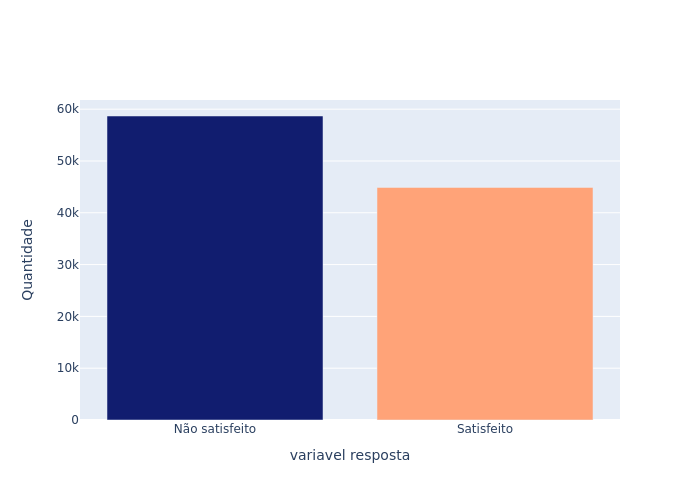

In [92]:
aux = df4[['satisfaction']].groupby('satisfaction').size().reset_index(name='qnt')

fig = go.Figure(go.Bar(x=aux['satisfaction'], y=aux['qnt'], marker_color=['#111D6F', '#FFA378']))
fig.update_layout(xaxis_title='variavel resposta',
                  yaxis_title='Quantidade',
                  xaxis=dict(tickmode = 'array', tickvals= [0,1], ticktext=['Não satisfeito', 'Satisfeito']),
                  showlegend = False, autosize=False)

fig.show('png')

## 4.2 Analise univariada

### 4.2.1 Distribuição da idade

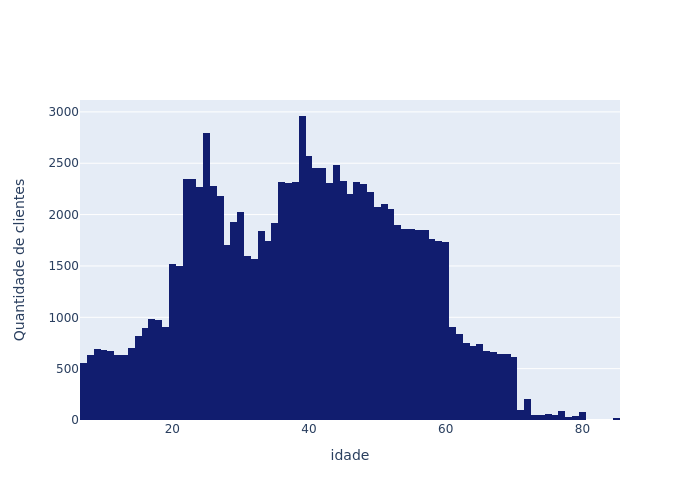

In [93]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=(df4['age']), marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='idade', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

### 4.2.2 Distribuição da distância da loja

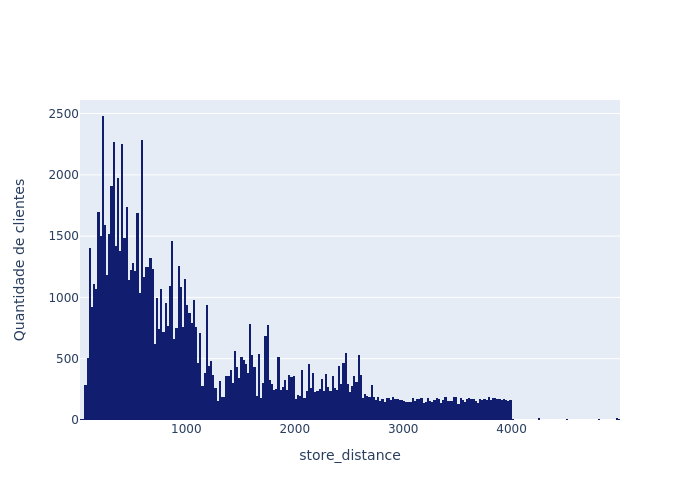

In [94]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=df4['store_distance'], marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='store_distance', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

### 4.2.3 Carrier delay

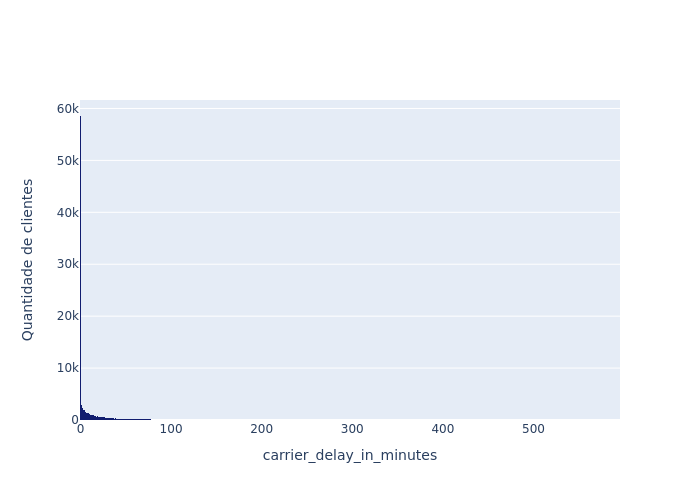

In [95]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df4['carrier_delay_in_minutes'], marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='carrier_delay_in_minutes', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

### 4.2.4 Delivery_delay

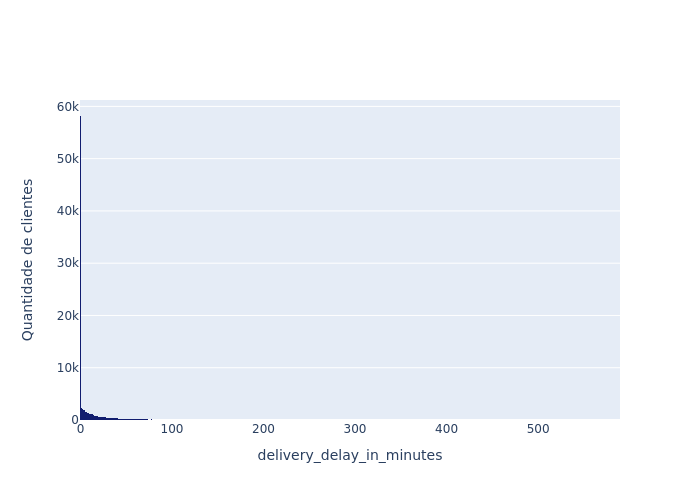

In [96]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df4['delivery_delay_in_minutes'], marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='delivery_delay_in_minutes', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

### 4.2.5 Distribução das váriaveis que são notas

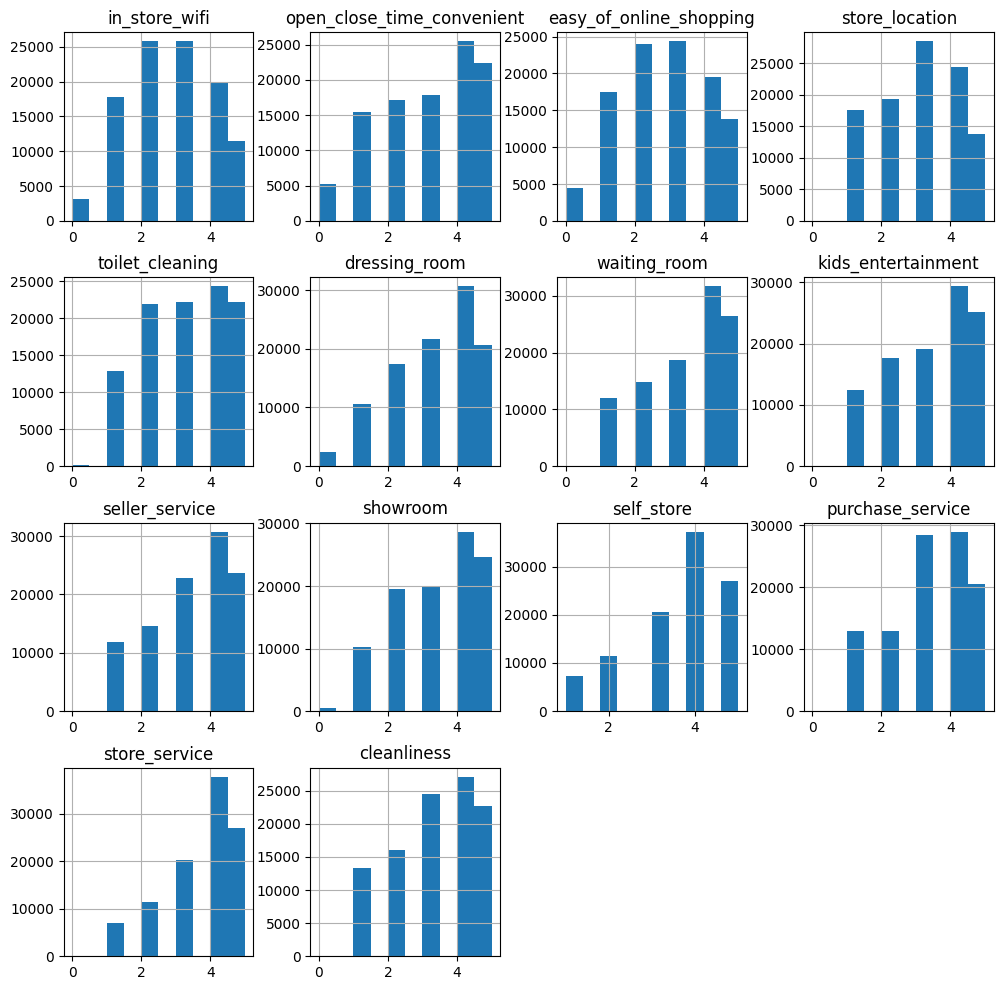

In [97]:
aux = df4[score_features]

aux.hist(grid=True, figsize=(12,12));

<Axes: >

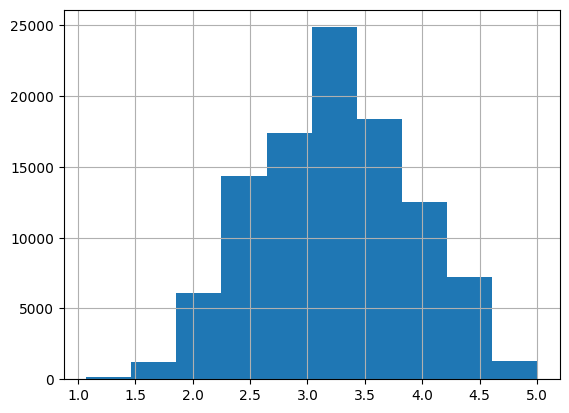

In [98]:
df4['media_score'].hist()

In [99]:
#gender                                       [Male, Female] (0 = Male, 1 = Female)
#customer_type           [Loyal Customer, disloyal Customer] (0 = Leal, 1 = "desleal")
#type_of_purchase                           [Personal, Gift] (0 = pessoal, 1 = presente)
#store_size                           [Small, Large, Medium] (1 = pequeno, 2=médio, 3=grande)
#satisfaction        [Neutral or Dissatisfaction, Satisfied] (0 = não satisfeito, 1 = satisfeito)

## 4.3 Analise Bivariada

### Validação das hipóteses

#### 4.3.1 Lojas

 ##### - 1. Lojas mais próximas de centro deveriam satisfazer mais o cliente.



#####  - 2. Lojas pequenas tem maior numero de clientes insatisfeitos

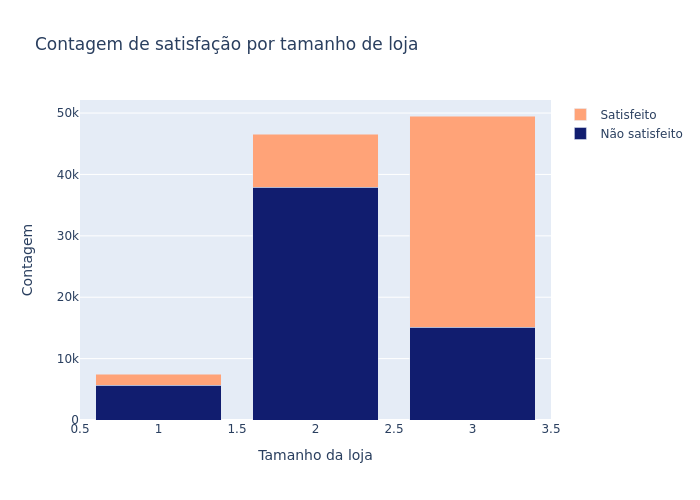

In [100]:
counts = df4.groupby(['store_size', 'satisfaction']).size().unstack().reset_index()

data = [go.Bar(x=counts['store_size'], y=counts[0], name='Não satisfeito',marker = dict(color='#111D6F')),
        go.Bar(x=counts['store_size'], y=counts[1], name='Satisfeito',marker = dict(color='#FFA378'))]

layout = go.Layout(title='Contagem de satisfação por tamanho de loja',
                   xaxis=dict(title='Tamanho da loja'),
                   yaxis=dict(title='Contagem'),
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)

fig.show('png')


#### 4.3.2 Clientes

##### - 1. Pessoas com mais que 45 anos tendem a  ficar insatisfeitas com a loja. (Lembrar de excluir a faixa etaria infantil)

In [101]:
bins = [0, 18, 45, float('inf')]
labels = ['0-18', '19-45', '45+']

aux=df4.copy()
aux['age_group'] = pd.cut(aux['age'], bins=bins, labels=labels, right=False)

counts = aux.groupby(['age_group', 'satisfaction']).size().unstack().reset_index()

data = [go.Bar(x=counts['age_group'],y=counts[0],name='Satisfação 0',marker=dict(color='#111D6F')),
        go.Bar(x=counts['age_group'],y=counts[1],name='Satisfação 1',marker=dict(color='#FFA378'))]

layout = go.Layout(title='Contagem de satisfação por faixa etária',
                   xaxis=dict(title='Faixa Etária'),
                   yaxis=dict(title='Contagem'),
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)
fig.show()


##### - 2. Mulheres tendem a ficar mais insatisfeitas com a loja

In [102]:
counts = df4.groupby(['gender', 'satisfaction']).size().unstack().reset_index()

data = [go.Bar(x=counts['gender'], y=counts[0], name='Não satisfeito',marker = dict(color='#111D6F')),
        go.Bar(x=counts['gender'], y=counts[1], name='Satisfeito',marker = dict(color='#FFA378'))]

layout = go.Layout(title='Contagem de satisfação por genero',
                   xaxis=dict(title='Genero'),
                   yaxis=dict(title='Contagem'),
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)

fig.show()

##### - 3. Clientes fieis tendem a serem mais satisfeitos com a loja

In [103]:
counts = df4.groupby(['customer_type', 'satisfaction']).size().unstack().reset_index()

data = [go.Bar(x=counts['customer_type'], y=counts[0], name='Não satisfeito',marker = dict(color='#111D6F')),
        go.Bar(x=counts['customer_type'], y=counts[1], name='Satisfeito',marker = dict(color='#FFA378'))]

layout = go.Layout(title='Contagem de satisfação por tipo de consumidor',
                   xaxis=dict(title='Tipo de consumidor'),
                   yaxis=dict(title='Contagem'),
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)

fig.show()

- 1. Clientes satisfeitos tendem a comprar para presentes


- 1. Tempo de entrega menor deveriam deixar o cliente mais satisfeitos

- 2. Os sites mais intuitivos deveriam deixar o cliente mais satisfeito

#### 4.3.3 Produto

##### - 1. Clientes satisfeitos tendem a comprar para presentes



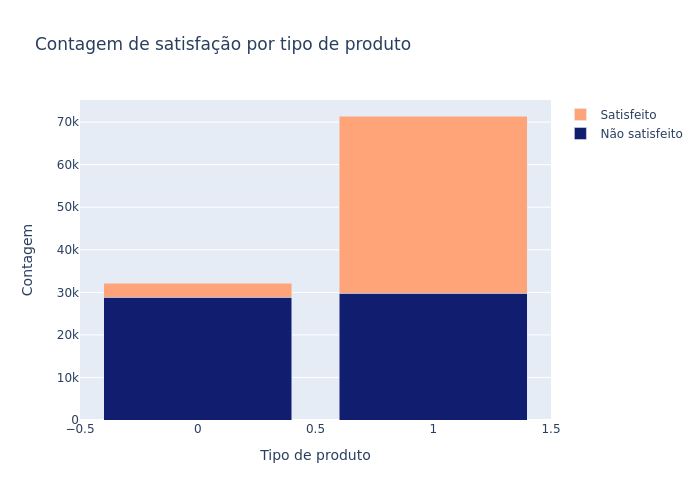

In [104]:
counts = df4.groupby(['type_of_purchase', 'satisfaction']).size().unstack().reset_index()

data = [go.Bar(x=counts['type_of_purchase'], y=counts[0], name='Não satisfeito',marker = dict(color='#111D6F')),
        go.Bar(x=counts['type_of_purchase'], y=counts[1], name='Satisfeito',marker = dict(color='#FFA378'))]

layout = go.Layout(title='Contagem de satisfação por tipo de produto',
                   xaxis=dict(title='Tipo de produto'),
                   yaxis=dict(title='Contagem'),
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)

fig.show('png')

#### 4.3.4 Experiencia do Cliente

##### - 1. Tempo de entrega menor deveriam deixar o cliente mais satisfeitos



##### - 2. Os sites mais intuitivos deveriam deixar o cliente mais satisfeito

# 5.0 Preparação dos dados

In [105]:
df5 = df4.copy()

In [106]:
mms_store_distance = pp.RobustScaler()
mms_carrier = pp.RobustScaler()
mms_delivery = pp.RobustScaler()

df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )

df5['carrier_delay_in_minutes'] = mms_carrier.fit_transform(df5[['carrier_delay_in_minutes']].values)
pickle.dump( mms_carrier, open( os.path.join(MODE_DIR,'carrier.pkl'), 'wb' ) )

df5['delivery_delay_in_minutes'] = mms_delivery.fit_transform(df5[['delivery_delay_in_minutes']].values)
pickle.dump( mms_delivery, open( os.path.join(MODE_DIR,'delivery.pkl'), 'wb' ) )


In [107]:
mms_in_store_wifi = pp.MinMaxScaler()
mms_open_close_time_convenient = pp.MinMaxScaler()
mms_easy_of_online_shopping = pp.MinMaxScaler()
mms_store_location = pp.MinMaxScaler()
mms_toilet_cleaning = pp.MinMaxScaler()
mms_dressing_room = pp.MinMaxScaler()
mms_waiting_room = pp.MinMaxScaler()
mms_kids_entertainment = pp.MinMaxScaler()
mms_seller_service = pp.MinMaxScaler()
mms_showroom = pp.MinMaxScaler()
mms_self_store = pp.MinMaxScaler()
mms_purchase_service = pp.MinMaxScaler()
mms_store_service = pp.MinMaxScaler()
mms_cleanlines = pp.MinMaxScaler()

#df5['in_store_wifi'] = mms_store_distance.fit_transform(df5[['in_store_wifi']].values)
#pickle.dump( mms_in_store_wifi, open( os.path.join(MODE_DIR,'in_store_wifi.pkl'), 'wb' ) )
#
#df5['open_close_time_convenient'] = mms_store_distance.fit_transform(df5[['open_close_time_convenient']].values)
#pickle.dump( mms_open_close_time_convenient, open( os.path.join(MODE_DIR,'open_close_time_convenient.pkl'), 'wb' ) )
#
#df5['open_close_time_convenient'] = mms_store_distance.fit_transform(df5[['open_close_time_convenient']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'open_close_time_convenient.pkl'), 'wb' ) )
#
#df5['open_close_time_convenient'] = mms_store_distance.fit_transform(df5[['open_close_time_convenient']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'open_close_time_convenient.pkl'), 'wb' ) )
#
#df5['open_close_time_convenient'] = mms_store_distance.fit_transform(df5[['open_close_time_convenient']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'open_close_time_convenient.pkl'), 'wb' ) )
#
#df5['open_close_time_convenient'] = mms_store_distance.fit_transform(df5[['open_close_time_convenient']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'open_close_time_convenient.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )
#
#df5['store_distance'] = mms_store_distance.fit_transform(df5[['store_distance']].values)
#pickle.dump( mms_store_distance, open( os.path.join(MODE_DIR,'store_distance.pkl'), 'wb' ) )


score_features

['in_store_wifi',
 'open_close_time_convenient',
 'easy_of_online_shopping',
 'store_location',
 'toilet_cleaning',
 'dressing_room',
 'waiting_room',
 'kids_entertainment',
 'seller_service',
 'showroom',
 'self_store',
 'purchase_service',
 'store_service',
 'cleanliness']

In [108]:
x_array = np.array(df5['age'])
normalized_arr = pp.normalize([x_array])
df5['age'] = normalized_arr[0]

df5['age'];

In [109]:
df5.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open_close_time_convenient,easy_of_online_shopping,...,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,media_score
0,70172,0,0,0.000958,0,1,-0.287651,3,4,3,...,4,3,4,4,5,5,2.083333,1.384615,0,3.857143
1,5047,0,1,0.001842,1,3,-0.457078,3,2,3,...,1,5,3,1,4,1,0.083333,0.461538,0,2.285714
2,110028,1,0,0.001915,1,3,0.225904,2,2,2,...,4,3,4,4,4,5,0.000000,0.000000,1,3.714286
3,24026,1,0,0.001842,1,3,-0.210843,2,5,5,...,2,5,3,1,4,2,0.916667,0.692308,0,3.000000
4,119299,0,0,0.004493,1,3,-0.472892,3,3,3,...,3,4,4,3,3,3,0.000000,0.000000,1,3.500000


# 6.0 ML

In [130]:
df6 = df5.copy()


In [131]:
X = df6.drop(['id','satisfaction'], axis = 1)
y = df6['satisfaction'].copy() 

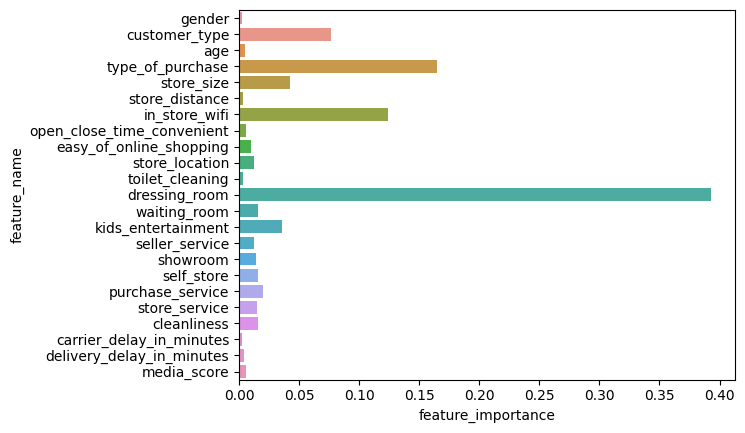

In [132]:
model_xgb = XGBClassifier(n_jobs=-1, n_estimators=300)

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
#scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
#score = np.mean(scores)
#print('Precision Score: %.3f' % (score))

model1 = model_xgb.fit(X, y)

feature_score1 = pd.DataFrame(
                            { 'feature_name': X.columns ,
                              'feature_importance': model1.feature_importances_ }
                            )
sns.barplot(data=feature_score1, x='feature_importance', y='feature_name');



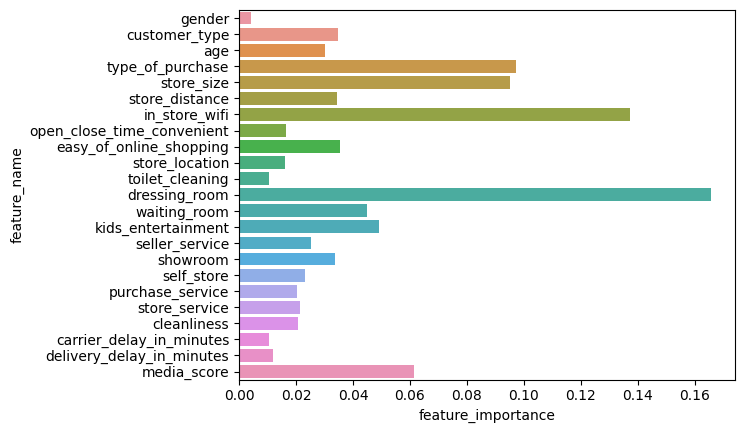

In [133]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=300)

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
#scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
#score = np.mean(scores)
#print('Precision Score: %.3f' % (score))

model1 = model.fit(X, y)

feature_score1 = pd.DataFrame(
                            { 'feature_name': X.columns ,
                              'feature_importance': model1.feature_importances_ }
                            )
sns.barplot(data=feature_score1, x='feature_importance', y='feature_name');

In [134]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25)

In [138]:
xgb = XGBClassifier()

xgb_cv=cross_val_score(xgb,x_train,y_train,cv=5,scoring='precision')
xgb_cv

array([0.97240533, 0.96485913, 0.96797804, 0.97101227, 0.96919068])

In [139]:
xgb_f = XGBClassifier().fit(X, y)

# Submissão

In [151]:
df_test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))

df_final = df_test.copy()

df_final.columns = ['id','gender','customer_type','age','type_of_purchase','store_size','store_distance','in_store_wifi',
               'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning','dressing_room','waiting_room',
               'kids_entertainment','seller_service','showroom','self_store','purchase_service','store_service','cleanliness','carrier_delay_in_minutes',
               'delivery_delay_in_minutes']

In [152]:
df_final['gender'] =             [0 if x == 'Male'                       else 1 for x in df_final['gender']]
df_final['customer_type'] =      [0 if x == 'Loyal Customer'             else 1 for x in df_final['customer_type']]
df_final['type_of_purchase'] =   [0 if x == 'Personal'                   else 1 for x in df_final['type_of_purchase']]
df_final['store_size'] =         [1 if x == 'Small'                      else 2 if x=='Medium' else 3 for x in df_final['store_size']]


In [153]:
df_final.loc[:,'store_distance'] = mms_store_distance.transform(df_final[['store_distance']].values)

df_final.loc[:,'carrier_delay_in_minutes'] = mms_carrier.transform(df_final[['carrier_delay_in_minutes']].values)

df_final.loc[:,'delivery_delay_in_minutes'] = mms_delivery.transform(df_final[['delivery_delay_in_minutes']].values)

x_array = np.array(df_final['age'])
normalized_arr = pp.normalize([x_array])
df_final['age'] = normalized_arr[0]

In [154]:
score_features = ['in_store_wifi','open_close_time_convenient','easy_of_online_shopping',
                  'store_location','toilet_cleaning','dressing_room','waiting_room','kids_entertainment',
                  'seller_service','showroom','self_store','purchase_service','store_service','cleanliness']

aux = df_final[score_features]
df_final['media_score'] = np.mean(aux, axis=1)

In [155]:
df_final = df_final.drop(['id'], axis = 1)

In [156]:
yhat_test = xgb_f.predict( df_final )

In [157]:
sub = pd.concat((df_test['id'], (pd.Series(yhat_test))), axis=1)

sub = sub.rename(columns={0:'Satisfaction'})

sub = sub.set_index('id')
sub
sub.to_csv('sub_xgb_model_8.csv')